# Prediction of particle size and yield for a continuous crystallisation process

Model selection
for this type of task we can always start with linear and polynomial regression models. these models can capture simple relationship between variables effectively. these are useful when system exhibit linear or slightly non linear behaviour. we can use these models if the process dynamics are relatively straightforward or if a first order approximation is sufficient. 
Crystallisation processes are often governed by non linear kinetics and thermodynamics and here we are interested in highly interpretable models which can give us good acurracy as well. to meet these objectives models like random forest, gradient boosting and lightLGM can be beneficial.

## Random forest model
Random Forest builds multiple decision trees and combines their predictions (for regression, it averages the predictions; for classification, it uses majority voting).
Each tree is trained on a random subset of the data (bootstrapping).	At each split in the tree, a random subset of features is considered for the best split.The randomness helps reduce overfitting by creating diverse trees.

## Data processing

### 1. Feature normalisation
Normalization scales the features (columns) of your dataset to a specific range, typically [0, 1]. This is useful in machine learning because many algorithms (e.g., gradient descent, distance-based algorithms like k-NN) work better or converge faster when the input features are on a similar scale.it is not a requirement for random forest though.
I performed feature normalization using the MinMaxScaler from the scikit-learn library. 
This creates an instance of MinMaxScaler, which is a scikit-learn class for normalization.
By default, it scales each feature (column) to the range [0, 1]. You can adjust the range by passing parameters like MinMaxScaler(feature_range=(a, b)), where a and b are the desired minimum and maximum values.
fit_transform() does two things:
Fit: It computes the minimum and maximum values of each feature in the dataset X.
Transform: It scales each feature according to the formula:
Xnormalised = X-Xmin/Xmax-Xmin
This ensures that all values are linearly mapped to the range [0, 1].

### 2. data Split
I performed stratified sequential split, where the data is initially divided into two subsets (training and a temporary set) and then further split into validation and test sets. This ensures that you have three distinct datasets for model training, hyperparameter tuning (validation), and evaluation (testing).
The dataset is divided into:
Training Set (X_train_ps, y_train_ps) – 60% of the data.
Temporary Set (X_temp_ps, y_temp_ps) – 40% of the data (to be further split).
This uses train_test_split() from scikit-learn, where:
test_size=0.4 means 40% of the data goes into the temporary set.
random_state=42 ensures reproducibility of the split.
The temporary set (X_temp_ps, y_temp_ps) is further split into:
Validation Set (X_val_ps, y_val_ps) – 50% of the temporary set (i.e., 20% of the original data).
Test Set (X_test_ps, y_test_ps) – 50% of the temporary set (i.e., 20% of the original data).

## Model parameters
two models one of particle size and one for yield
n_estimators=100: Specifies the number of decision trees in the forest.More trees generally improve performance up to a certain point but increase computation time.
random_state=42: Ensures reproducibility by setting a seed for the random number generator used in the algorithm. Using the same random state ensures consistent results across runs.


In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Load your dataset
data = pd.read_excel("crystallisation_data.xlsx")

# Features (X) and targets (y)
X = data[['V_stage1', 'V_stage2', 'V_stage3', 'seed_flowrate', 'feed_flowrate', 'T_stage1', 'T_stage2', 'T_stage3']]
y = data[['particle_size', 'yield']]

# Normalize features (X) using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)  # Normalize X

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 38.022378791258554
R2 Score: 0.9793219344720467



Particle Size - Performance Metrics:
Train RMSE: 2.778, Train R²: 0.997
Validation RMSE: 7.964, Validation R²: 0.977
Test RMSE: 8.522, Test R²: 0.974


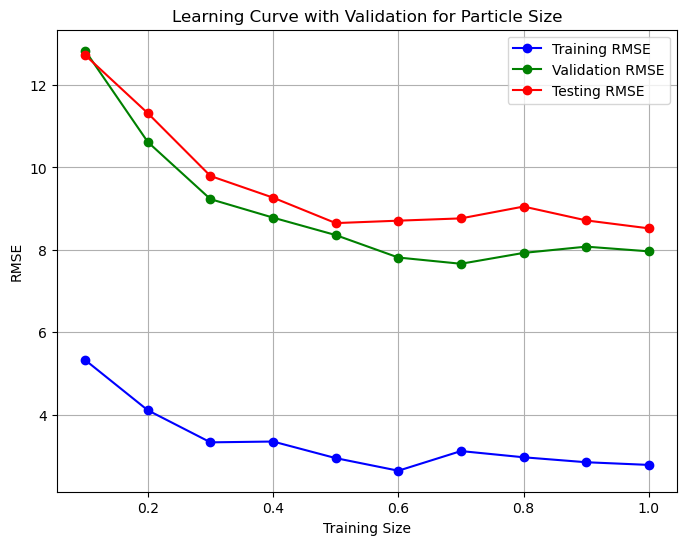

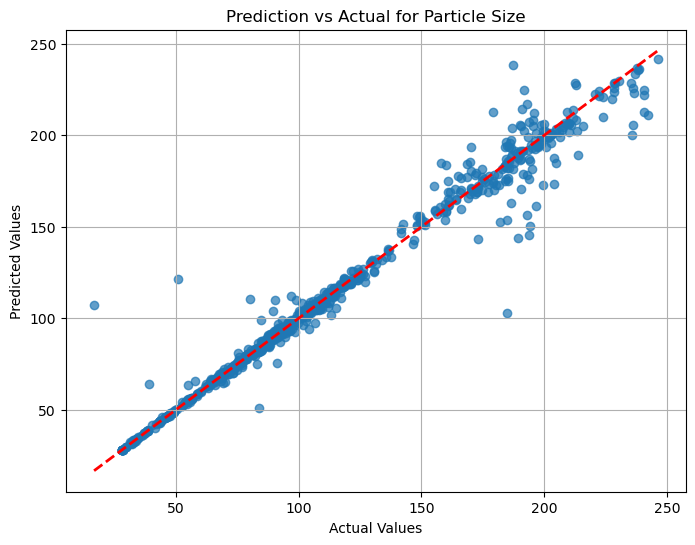

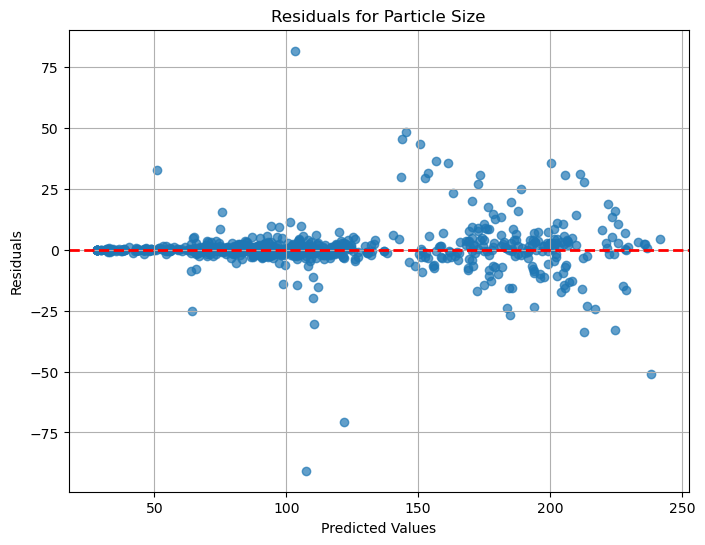

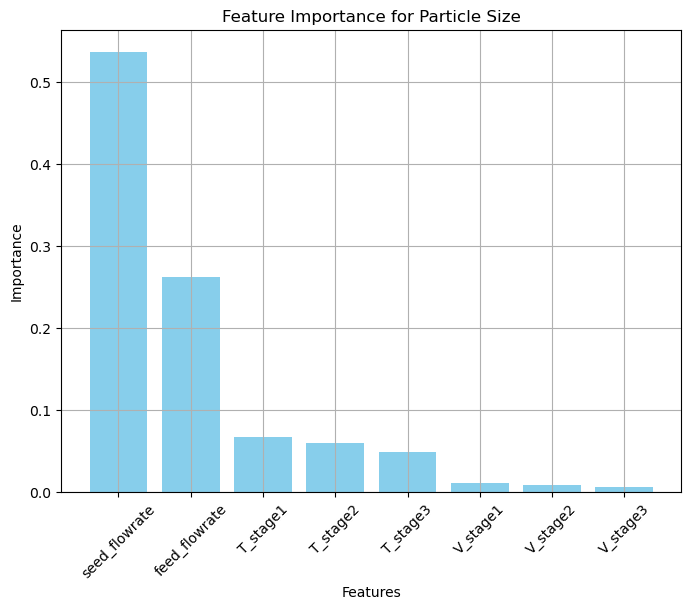


Yield - Performance Metrics:
Train RMSE: 0.020, Train R²: 1.000
Validation RMSE: 0.055, Validation R²: 0.998
Test RMSE: 0.043, Test R²: 0.999


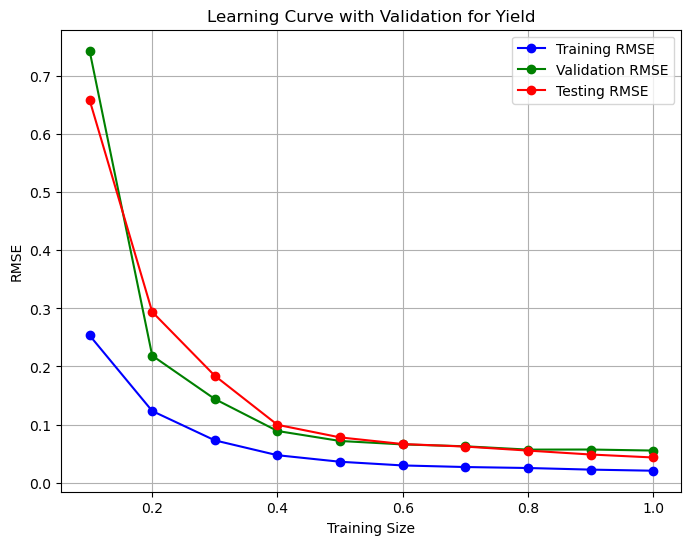

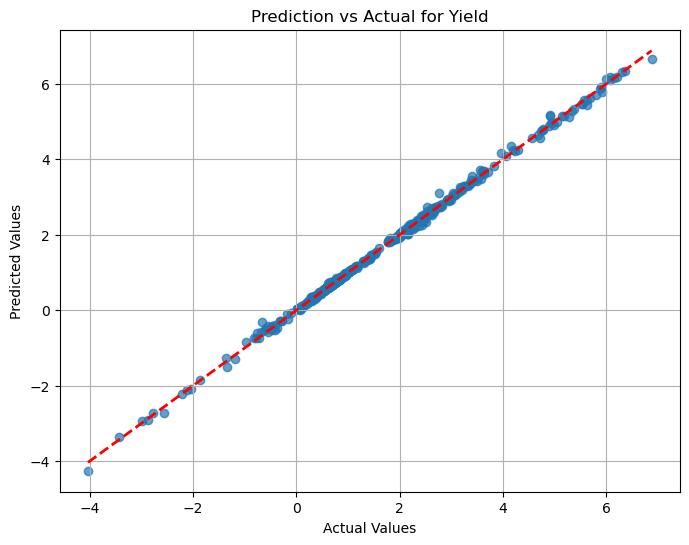

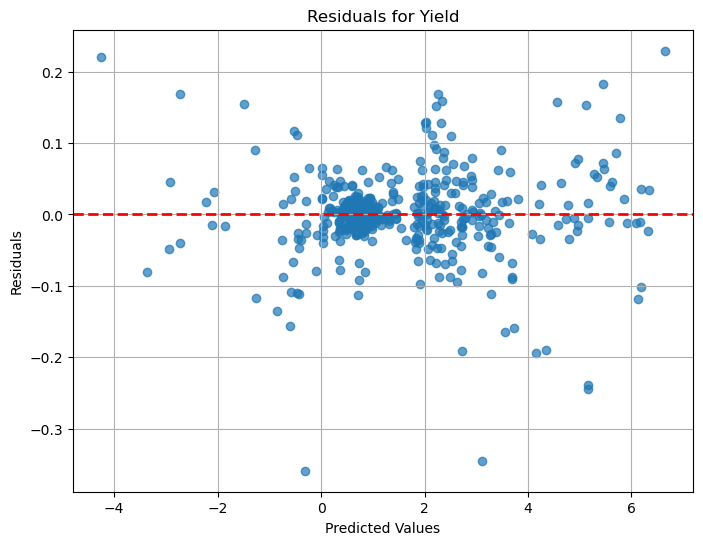

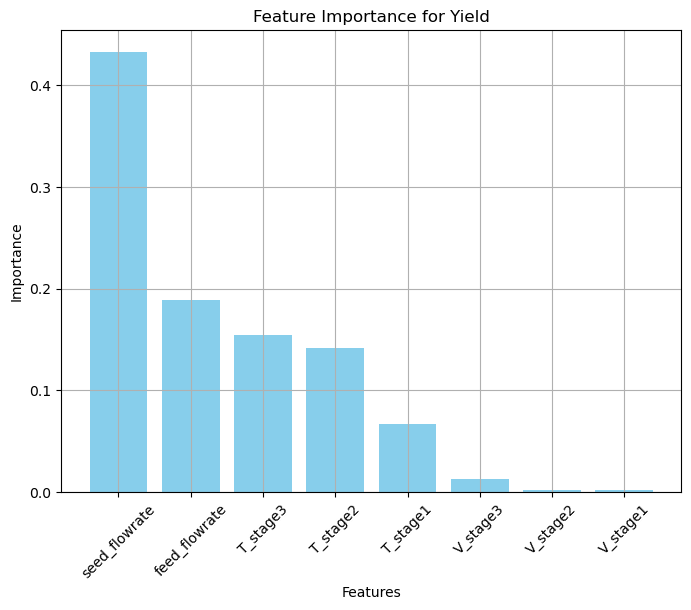

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
data = pd.read_excel("crystallisation_data.xlsx")

# Features (X) and targets (y)
X = data[['V_stage1', 'V_stage2', 'V_stage3', 'T_stage1', 'T_stage2', 'T_stage3', 'feed_flowrate', 'seed_flowrate']]
y_particle_size = data['particle_size']  # Target 1
y_yield = data['yield']  # Target 2

# Normalize features (X) using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Split dataset into train, validation, and test sets for 'particle_size'
X_train_ps, X_temp_ps, y_train_ps, y_temp_ps = train_test_split(X_normalized, y_particle_size, test_size=0.4, random_state=42)
X_val_ps, X_test_ps, y_val_ps, y_test_ps = train_test_split(X_temp_ps, y_temp_ps, test_size=0.5, random_state=42)

# Split dataset into train, validation, and test sets for 'yield'
X_train_yield, X_temp_yield, y_train_yield, y_temp_yield = train_test_split(X_normalized, y_yield, test_size=0.4, random_state=42)
X_val_yield, X_test_yield, y_val_yield, y_test_yield = train_test_split(X_temp_yield, y_temp_yield, test_size=0.5, random_state=42)

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, target_name):
    """
    Train the model, evaluate RMSE and R² on training, validation, and test sets,
    and generate the plots.
    """
    # Train the model on the full training set
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Calculate R²
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Print results
    print(f"\n{target_name} - Performance Metrics:")
    print(f"Train RMSE: {train_rmse:.3f}, Train R²: {train_r2:.3f}")
    print(f"Validation RMSE: {val_rmse:.3f}, Validation R²: {val_r2:.3f}")
    print(f"Test RMSE: {test_rmse:.3f}, Test R²: {test_r2:.3f}")
    
    # Generate Plots
    plot_learning_curve_rf_with_validation(model, X_train, y_train, X_val, y_val, X_test, y_test, target_name)
    plot_prediction_vs_actual(y_test, y_test_pred, target_name)
    plot_residuals(y_test, y_test_pred, target_name)
    plot_feature_importance(model, target_name)

def plot_learning_curve_rf_with_validation(model, X_train, y_train, X_val, y_val, X_test, y_test, target_name):
    """
    Plot learning curve for a RandomForestRegressor model.
    """
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_errors = []
    val_errors = []
    test_errors = []

    for train_size in train_sizes:
        # Determine the subset of training data to use
        subset_size = int(train_size * len(X_train))
        X_train_subset = X_train[:subset_size]
        y_train_subset = y_train[:subset_size]
        
        # Fit the model on the subset of training data
        model.fit(X_train_subset, y_train_subset)
        
        # Predictions for the subset of training data
        train_pred = model.predict(X_train_subset)
        # Predictions for the validation set
        val_pred = model.predict(X_val)
        # Predictions for the test set
        test_pred = model.predict(X_test)
        
        # Calculate MSE for training, validation, and testing
        train_errors.append(mean_squared_error(y_train_subset, train_pred))
        val_errors.append(mean_squared_error(y_val, val_pred))
        test_errors.append(mean_squared_error(y_test, test_pred))
    
    # Plot the learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, np.sqrt(train_errors), label='Training RMSE', marker='o', color='blue')
    plt.plot(train_sizes, np.sqrt(val_errors), label='Validation RMSE', marker='o', color='green')
    plt.plot(train_sizes, np.sqrt(test_errors), label='Testing RMSE', marker='o', color='red')
    plt.xlabel('Training Size')
    plt.ylabel('RMSE')
    plt.title(f'Learning Curve with Validation for {target_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_prediction_vs_actual(y_actual, y_pred, target_name):
    """
    Plot Prediction vs Actual values.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_pred, alpha=0.7)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Prediction vs Actual for {target_name}')
    plt.grid(True)
    plt.show()

def plot_residuals(y_actual, y_pred, target_name):
    """
    Plot residuals (errors) for predictions.
    """
    residuals = y_actual - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals for {target_name}')
    plt.grid(True)
    plt.show()

def plot_feature_importance(model, target_name):
    """
    Plot feature importance for RandomForestRegressor.
    """
    importance = model.feature_importances_
    features = ['V_stage1', 'V_stage2', 'V_stage3', 'T_stage1', 'T_stage2', 'T_stage3', 'feed_flowrate', 'seed_flowrate']
    sorted_idx = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(8, 6))
    plt.bar(np.array(features)[sorted_idx], importance[sorted_idx], color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance for {target_name}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Initialize RandomForestRegressor models
model_ps = RandomForestRegressor(n_estimators=100, random_state=42)
model_yield = RandomForestRegressor(n_estimators=100, random_state=42)

# Evaluate and plot for Particle Size
evaluate_model(model_ps, X_train_ps, y_train_ps, X_val_ps, y_val_ps, X_test_ps, y_test_ps, "Particle Size")

# Evaluate and plot for Yield
evaluate_model(model_yield, X_train_yield, y_train_yield, X_val_yield, y_val_yield, X_test_yield, y_test_yield, "Yield")

# Outcomes
yield performance metrics shows RMSE of 0.02-0.05. and R2 vales were above 99.8 which is a high accuracy of prediction. for yield learning curve showed a good convergence of error between different data sets.
particle size error was higher which was 7.7 and R2 was 97.7. I picked RMSE as performance metric because it gives you error in the same units as your data and the error we are seeing is acceptable. the only issue we see is the learning rate curve shows not a good convergence for RMSE for training test and validation data sets. 
## robustness of model performance
i used K-Fold cross validation to check the robustness of the model.
1.	The dataset is divided into K equally sized subsets (called folds).
2.	For each iteration
	One fold is used as the test se
	The remaining K-1 folds are used as the training set.4
3.	This process is repeated K times (folds)5
4.	The performance mete.g., RMS MAE) from each fold are averaged to obtain the final model performance.



Particle Size - Cross-Validation Results:
Fold 1: RMSE = 8.640, R² = 0.973
Fold 2: RMSE = 7.197, R² = 0.981
Fold 3: RMSE = 7.142, R² = 0.980
Fold 4: RMSE = 7.974, R² = 0.974
Fold 5: RMSE = 7.440, R² = 0.979

Aggregate Metrics: Average RMSE = 7.679, Average R² = 0.977


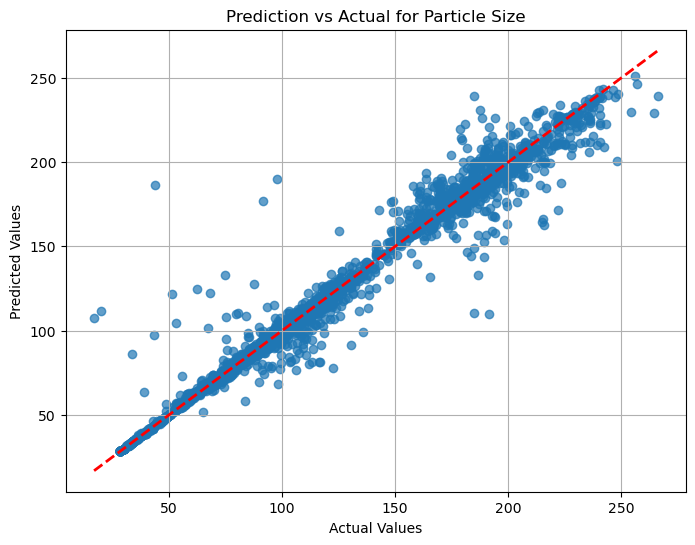

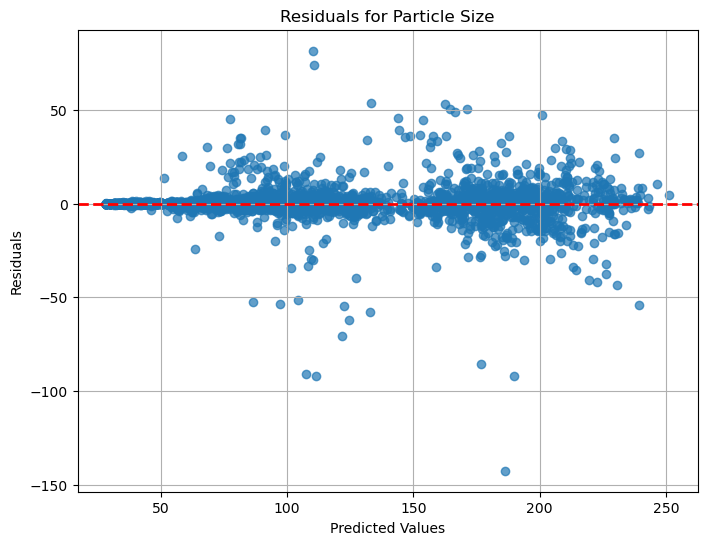

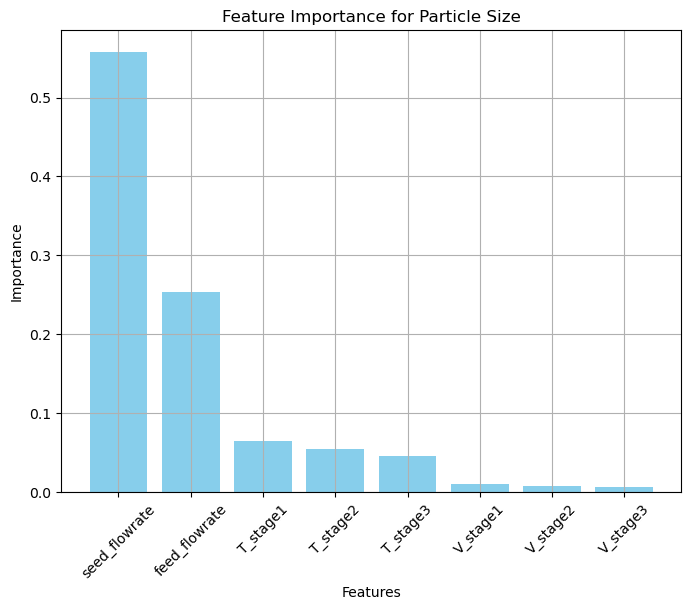


Yield - Cross-Validation Results:
Fold 1: RMSE = 0.046, R² = 0.999
Fold 2: RMSE = 0.043, R² = 0.999
Fold 3: RMSE = 0.057, R² = 0.998
Fold 4: RMSE = 0.048, R² = 0.999
Fold 5: RMSE = 0.051, R² = 0.999

Aggregate Metrics: Average RMSE = 0.049, Average R² = 0.999


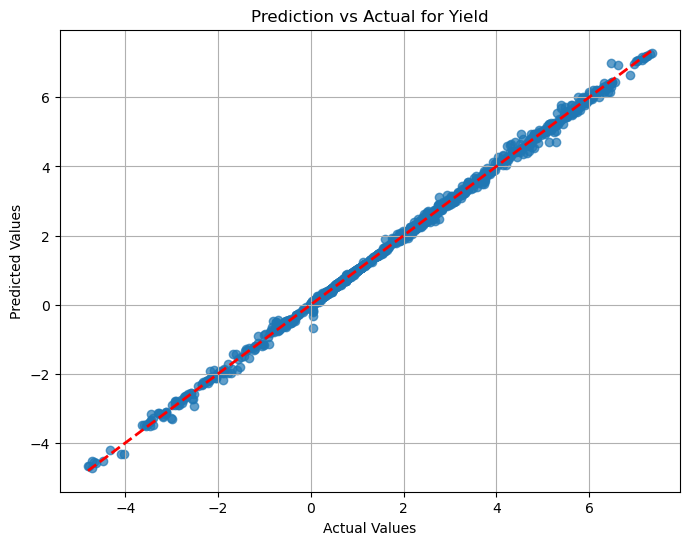

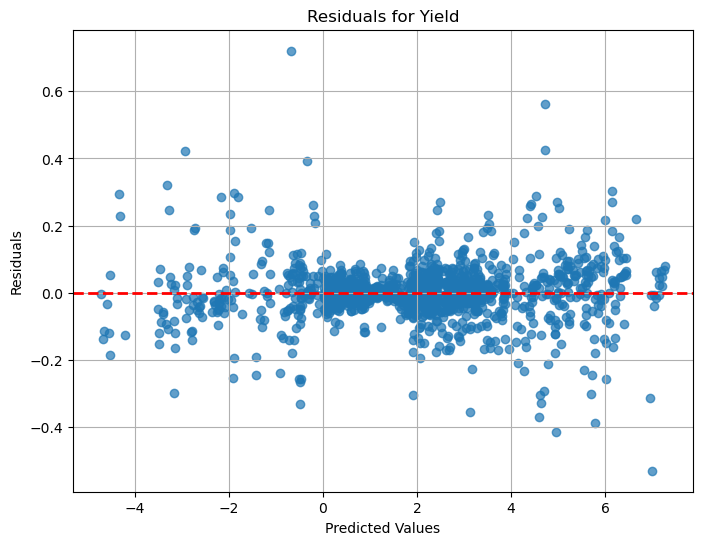

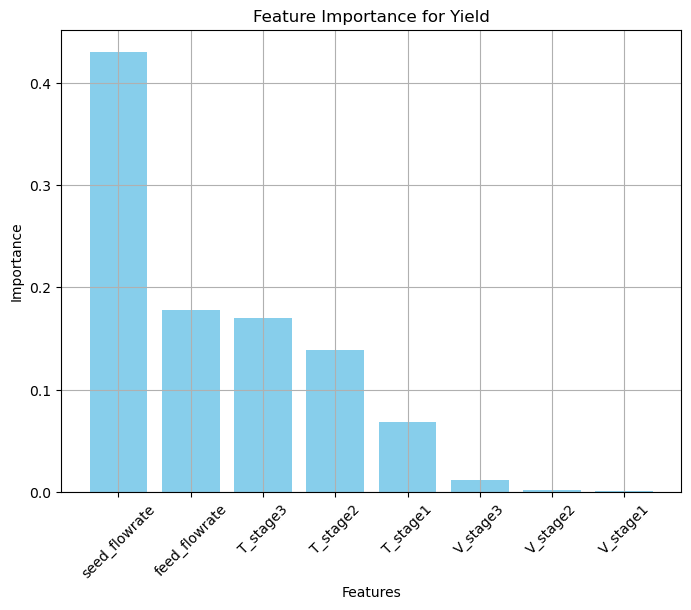

(0.04910845474425528, 0.9987352185954699)

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_excel("crystallisation_data.xlsx")

# Features (X) and targets (y)
X = data[['V_stage1', 'V_stage2', 'V_stage3', 'T_stage1', 'T_stage2', 'T_stage3', 'feed_flowrate', 'seed_flowrate']]
y_particle_size = data['particle_size']  # Target 1
y_yield = data['yield']  # Target 2

# Normalize features (X) using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

def k_fold_cross_validation(model, X, y, n_splits=5, target_name="Target"):
    """
    Perform K-Fold cross-validation, evaluate RMSE and R² for each fold, 
    and generate aggregate metrics and plots.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_rmse = []
    fold_r2 = []
    y_actual_all = []
    y_pred_all = []
    
    print(f"\n{target_name} - Cross-Validation Results:")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        # Split the data into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on the validation set
        y_val_pred = model.predict(X_val)
        
        # Store actual and predicted values for plotting
        y_actual_all.extend(y_val)
        y_pred_all.extend(y_val_pred)
        
        # Calculate RMSE and R²
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        r2 = r2_score(y_val, y_val_pred)
        
        fold_rmse.append(rmse)
        fold_r2.append(r2)
        
        print(f"Fold {fold}: RMSE = {rmse:.3f}, R² = {r2:.3f}")
    
    # Aggregate results
    avg_rmse = np.mean(fold_rmse)
    avg_r2 = np.mean(fold_r2)
    print(f"\nAggregate Metrics: Average RMSE = {avg_rmse:.3f}, Average R² = {avg_r2:.3f}")
    
    # Generate plots
    plot_prediction_vs_actual(np.array(y_actual_all), np.array(y_pred_all), target_name)
    plot_residuals(np.array(y_actual_all), np.array(y_pred_all), target_name)
    plot_feature_importance(model, target_name)
    
    return avg_rmse, avg_r2

def plot_prediction_vs_actual(y_actual, y_pred, target_name):
    """
    Plot Prediction vs Actual values.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_pred, alpha=0.7)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Prediction vs Actual for {target_name}')
    plt.grid(True)
    plt.show()

def plot_residuals(y_actual, y_pred, target_name):
    """
    Plot residuals (errors) for predictions.
    """
    residuals = y_actual - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals for {target_name}')
    plt.grid(True)
    plt.show()

def plot_feature_importance(model, target_name):
    """
    Plot feature importance for RandomForestRegressor.
    """
    importance = model.feature_importances_
    features = ['V_stage1', 'V_stage2', 'V_stage3', 'T_stage1', 'T_stage2', 'T_stage3', 'feed_flowrate', 'seed_flowrate']
    sorted_idx = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(8, 6))
    plt.bar(np.array(features)[sorted_idx], importance[sorted_idx], color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance for {target_name}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Initialize RandomForestRegressor model
model_ps = RandomForestRegressor(n_estimators=100, random_state=42)
model_yield = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform K-Fold Cross-Validation for Particle Size
k_fold_cross_validation(model_ps, X_normalized, y_particle_size, n_splits=5, target_name="Particle Size")

# Perform K-Fold Cross-Validation for Yield
k_fold_cross_validation(model_yield, X_normalized, y_yield, n_splits=5, target_name="Yield")

outcome shows robustness of model predictions as results matched with the model where we use strtified split

# XGBoost (extreme gradiant boosting)
Boosting Algorithm: Builds trees sequentially, where each tree corrects the errors of the previous ones. This is known as gradient boosting
Uses a gradient descent approach to minimize a loss function (e.g., Mean Squared Error for regression).
Incorporates regularization terms (L1/L2) to prevent overfitting.
Splits are optimized using second-order gradients (Hessian) for faster convergence.
Employs efficient parallelization to speed up training.
## Advantages of this model
o	Highly accurate due to sequential learning and advanced optimization techniques.
o	Regularization reduces the risk of overfitting.
o	Handles missing values natively.
o	Includes hyperparameters for fine-grained coolntr
I choose this one to overcome overfitt through regularisation and convergence of error for achieving a well generallised model as compared toiin random forest mdell.


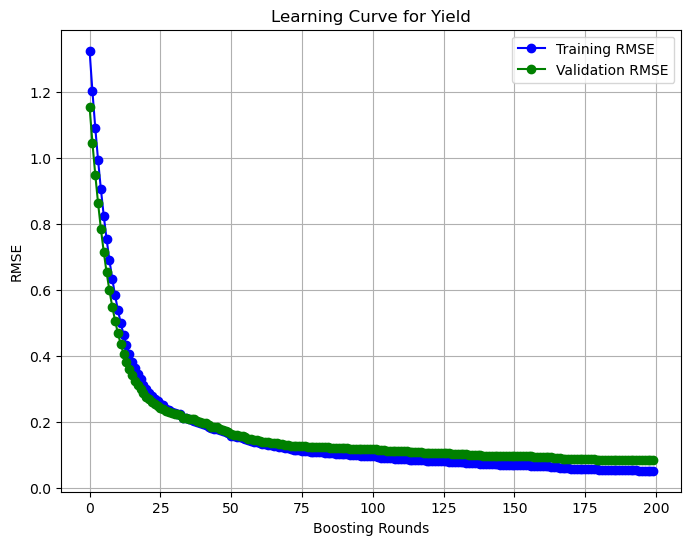


Yield - Performance Metrics:
Train RMSE: 0.053, Train R²: 0.999
Validation RMSE: 0.085, Validation R²: 0.996
Test RMSE: 0.115, Test R²: 0.992


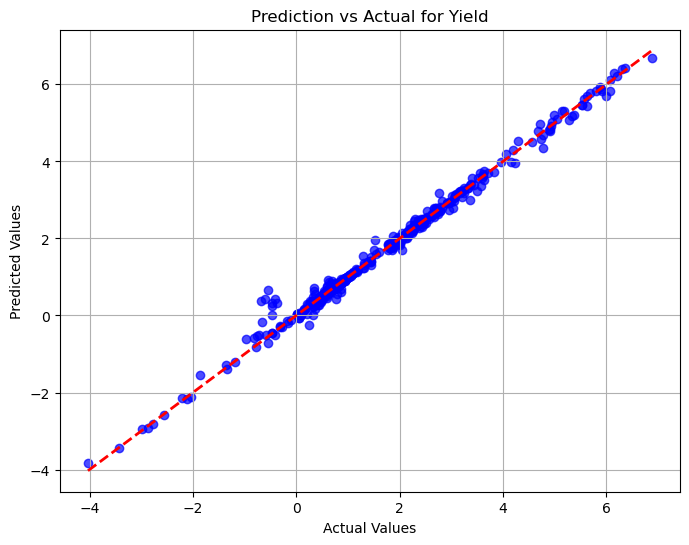

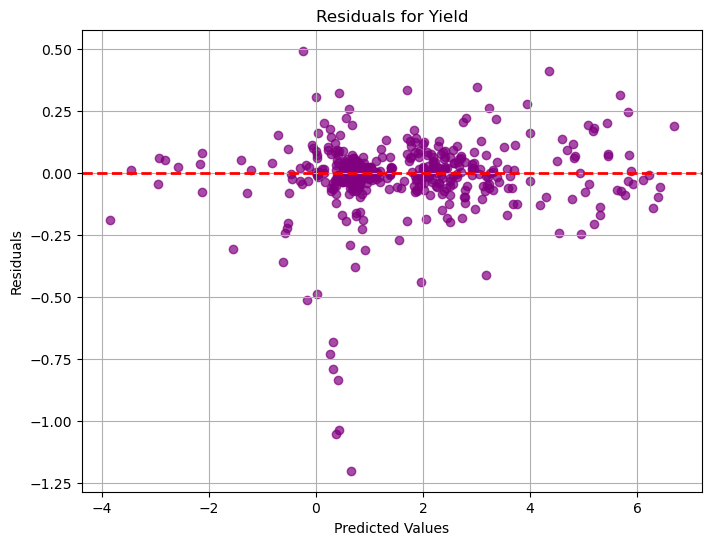

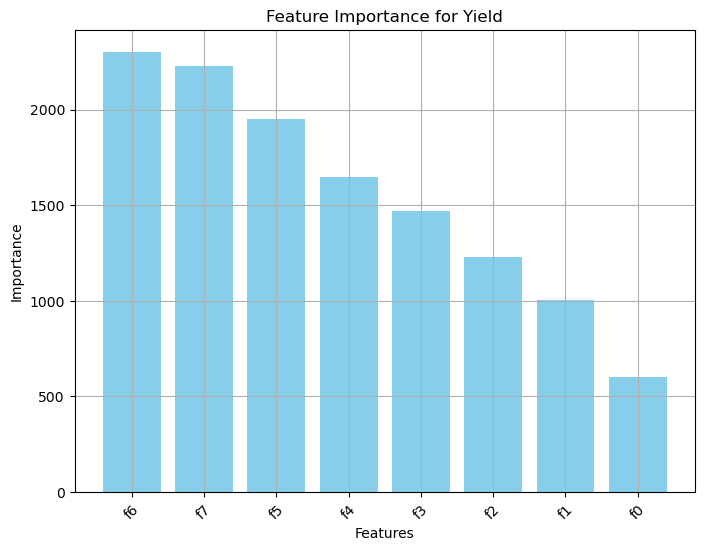

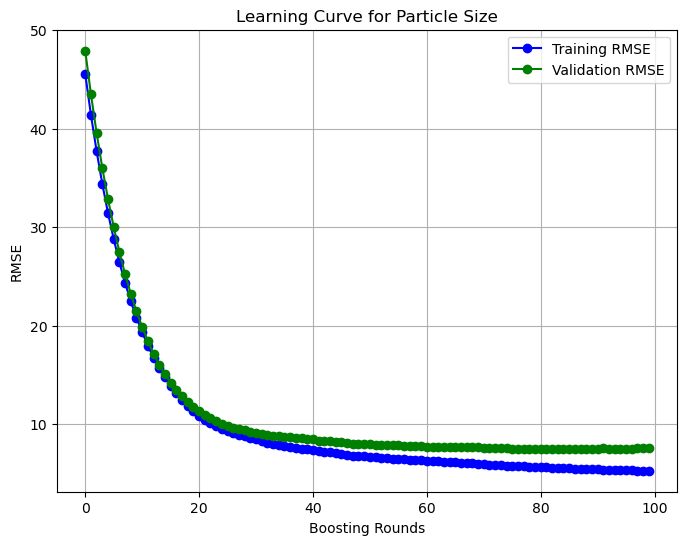


Particle Size - Performance Metrics:
Train RMSE: 5.266, Train R²: 0.989
Validation RMSE: 7.533, Validation R²: 0.980
Test RMSE: 7.731, Test R²: 0.979


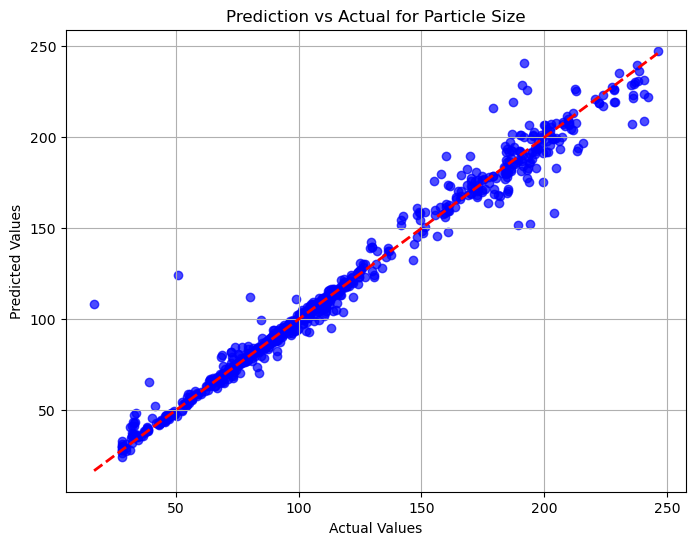

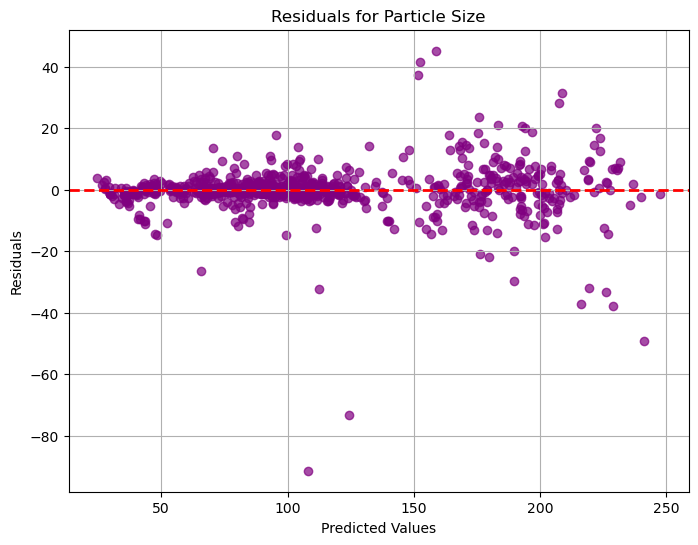

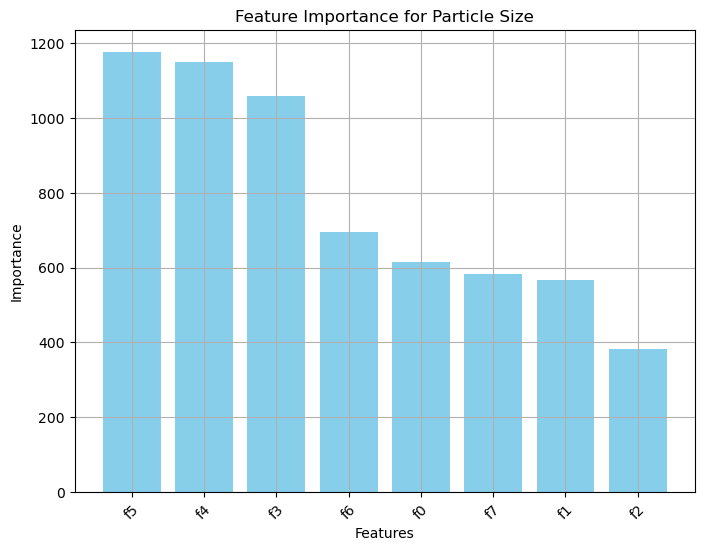

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load your dataset
data = pd.read_excel("crystallisation_data.xlsx")

# Features (X) and targets (y)
X = data[['V_stage1', 'V_stage2', 'V_stage3', 'T_stage1', 'T_stage2', 'T_stage3', 'feed_flowrate', 'seed_flowrate']]
y_yield = data['yield']  # Target 1
y_particle_size = data['particle_size']  # Target 2

# Normalize features (X) using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)  # Normalize X

# Function to split data into train, validation, and test sets
def split_data(X, y, test_size=0.4, val_size=0.5, random_state=42):
    """
    Split the dataset into train, validation, and test sets.
    """
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Function to train model, evaluate metrics, and generate plots
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, target_name):
    """
    Train XGBoost model, calculate metrics, and generate plots.
    """
    # Convert datasets to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set XGBoost parameters
    params = {
        'objective': 'reg:squarederror',  # Regression objective
        'eval_metric': 'rmse',           # Evaluate using RMSE
        'learning_rate': 0.1,
        'max_depth': 6,
        'seed': 42
    }

    # Train model with early stopping
    evals = [(dtrain, 'train'), (dval, 'eval')]
    evals_result = {}  # Store evaluation results
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,
        evals=evals,
        early_stopping_rounds=10,
        verbose_eval=False,
        evals_result=evals_result
    )

    # Plot learning curves
    plot_learning_curves(evals_result, target_name)

    # Evaluate metrics
    y_train_pred = model.predict(dtrain)
    y_val_pred = model.predict(dval)
    y_test_pred = model.predict(dtest)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"\n{target_name} - Performance Metrics:")
    print(f"Train RMSE: {train_rmse:.3f}, Train R²: {train_r2:.3f}")
    print(f"Validation RMSE: {val_rmse:.3f}, Validation R²: {val_r2:.3f}")
    print(f"Test RMSE: {test_rmse:.3f}, Test R²: {test_r2:.3f}")

    # Generate additional plots
    plot_prediction_vs_actual(y_test, y_test_pred, target_name)
    plot_residuals(y_test, y_test_pred, target_name)
    plot_feature_importance(model, target_name)

def plot_learning_curves(evals_result, target_name):
    """
    Plot learning curves for train and validation RMSE.
    """
    train_rmse = evals_result['train']['rmse']
    val_rmse = evals_result['eval']['rmse']
    plt.figure(figsize=(8, 6))
    plt.plot(train_rmse, label='Training RMSE', marker='o', color='blue')
    plt.plot(val_rmse, label='Validation RMSE', marker='o', color='green')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('RMSE')
    plt.title(f'Learning Curve for {target_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_prediction_vs_actual(y_actual, y_pred, target_name):
    """
    Plot Prediction vs Actual values.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_pred, alpha=0.7, color='blue')
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Prediction vs Actual for {target_name}')
    plt.grid(True)
    plt.show()

def plot_residuals(y_actual, y_pred, target_name):
    """
    Plot residuals (errors) for predictions.
    """
    residuals = y_actual - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.7, color='purple')
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals for {target_name}')
    plt.grid(True)
    plt.show()

def plot_feature_importance(model, target_name):
    """
    Plot feature importance from an XGBoost model.
    """
    importance = model.get_score(importance_type='weight')
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    features, scores = zip(*sorted_importance)
    plt.figure(figsize=(8, 6))
    plt.bar(features, scores, color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance for {target_name}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Split data for 'yield'
X_train, X_val, X_test, y_train_yield, y_val_yield, y_test_yield = split_data(X_normalized, y_yield)

# Train, evaluate, and plot for 'yield'
train_and_evaluate(X_train, y_train_yield, X_val, y_val_yield, X_test, y_test_yield, "Yield")

# Split data for 'particle_size'
X_train, X_val, X_test, y_train_ps, y_val_ps, y_test_ps = split_data(X_normalized, y_particle_size)

# Train, evaluate, and plot for 'particle_size'
train_and_evaluate(X_train, y_train_ps, X_val, y_val_ps, X_test, y_test_ps, "Particle Size")

there wasnot any improvment in model performance but concvergence of RMSE for particle size was much better then random forest model. 
in order to mind more optimal trees i tried Light GBM
## LightGBM
Similar to XGBoost, LightGBM uses gradient boosting to build trees sequentially.
Instead of growing trees level by level (as XGBoost does), LightGBM grows trees leaf-wise. This means it expands the leaf with the highest loss, leading to deeper and more optimal trees.
Uses histogram-based splitting for faster training.
Handles categorical features directly without one-hot encoding
it gives better performance on high dimension data and faster training as compared to XGBoost


Particle Size - Test Set Performance:
RMSE: 7.602
R2 Score: 0.979


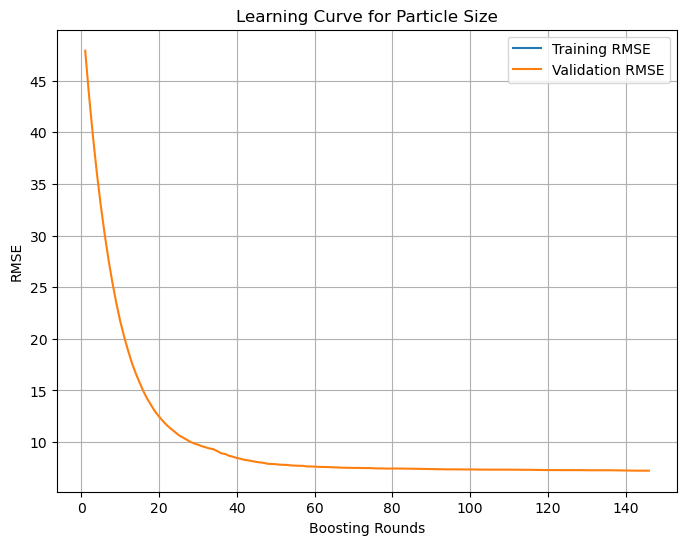

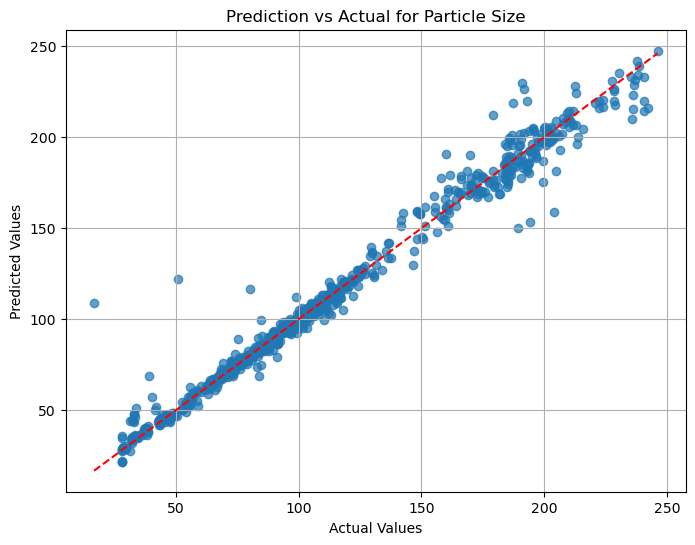

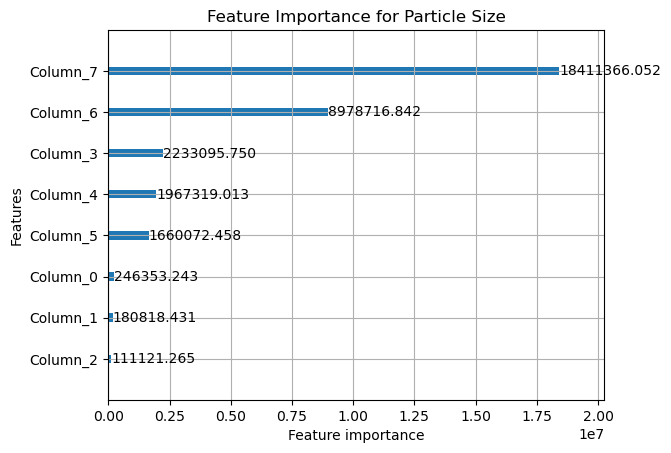

In [29]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load your dataset
data = pd.read_excel("crystallisation_data.xlsx")

# Features (X) and targets (y)
X = data[['V_stage1', 'V_stage2', 'V_stage3', 'T_stage1', 'T_stage2', 'T_stage3', 'feed_flowrate', 'seed_flowrate']]
y_particle_size = data['particle_size']  # Target 1
y_yield = data['yield']  # Target 2

# Normalize features (X) using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Split data for 'particle_size'
X_train_ps, X_temp_ps, y_train_ps, y_temp_ps = train_test_split(X_normalized, y_particle_size, test_size=0.4, random_state=42)
X_val_ps, X_test_ps, y_val_ps, y_test_ps = train_test_split(X_temp_ps, y_temp_ps, test_size=0.5, random_state=42)

# Convert to LightGBM Dataset
train_data_ps = lgb.Dataset(X_train_ps, label=y_train_ps)
val_data_ps = lgb.Dataset(X_val_ps, label=y_val_ps, reference=train_data_ps)

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6,
    'verbosity': -1,  # Suppress output
    'random_state': 42,
}

# Manual early stopping setup
num_boost_round = 200
best_rmse = float('inf')
best_iteration = 0
train_rmse_history = []
val_rmse_history = []

for i in range(1, num_boost_round + 1):
    model_ps = lgb.train(params, train_data_ps, num_boost_round=i, valid_sets=[val_data_ps], callbacks=[lgb.log_evaluation(0)])  # Logging controlled by callbacks
    y_val_pred = model_ps.predict(X_val_ps)
    current_rmse = np.sqrt(mean_squared_error(y_val_ps, y_val_pred))
    
    train_rmse = model_ps.best_score['training']['rmse'] if 'training' in model_ps.best_score else np.nan
    train_rmse_history.append(train_rmse)
    val_rmse_history.append(current_rmse)
    
    if current_rmse < best_rmse:
        best_rmse = current_rmse
        best_iteration = i

# Train model on the best iteration
model_ps = lgb.train(params, train_data_ps, num_boost_round=best_iteration)

# Evaluate on test set
y_pred_ps = model_ps.predict(X_test_ps)
rmse_ps = np.sqrt(mean_squared_error(y_test_ps, y_pred_ps))
r2_ps = r2_score(y_test_ps, y_pred_ps)

print("\nParticle Size - Test Set Performance:")
print(f"RMSE: {rmse_ps:.3f}")
print(f"R2 Score: {r2_ps:.3f}")

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, best_iteration + 1), train_rmse_history[:best_iteration], label='Training RMSE')
plt.plot(range(1, best_iteration + 1), val_rmse_history[:best_iteration], label='Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Learning Curve for Particle Size')
plt.legend()
plt.grid(True)
plt.show()

# Plot Prediction vs Actual for Particle Size
plt.figure(figsize=(8, 6))
plt.scatter(y_test_ps, y_pred_ps, alpha=0.7)
plt.plot([y_test_ps.min(), y_test_ps.max()], [y_test_ps.min(), y_test_ps.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual for Particle Size')
plt.grid(True)
plt.show()

# Plot Feature Importance for Particle Size
lgb.plot_importance(model_ps, max_num_features=10, importance_type='gain')
plt.title('Feature Importance for Particle Size')
plt.show()

performance was improved minimal with this model. results from these models dictate that random forest model gives reasonable good prediction but low convergence for performance metrics. XGboost shows similar performance but good convergence of RMSE. and performance of these two models was accurate enough for the evaluation of effect of process and operational parameters on the quality attributes.

# Hyperparameter tuning 
hyperparameter tuning was performed using Optuna and baysian optimisation for XGBoost.
Hyperparameters
Learning rate: Step size shrinkage to prevent overfitting
Number of trees: Number of boosting rounds, 
maximum depth: Maximum depth of each tree, 
subsample: Fraction of training data used for training each tree, 
Colsample bytree: Fraction of features considered for each tree, 
regularisation: L2 and L1 regularization parameters
## Optuna
Optuna is an excellent tool for hyperparameter tuning, and it can be particularly useful for optimizing models like Random Forest, XGBoost, and LightGBM. It is highly flexible, efficient, and well-suited for machine learning tasks with large or complex search spaces.
Allows custom objective functions, making it easy to tailor the optimization process.
Uses Tree-Structured Parzen Estimator (TPE) for intelligent exploration of the hyperparameter space.
Prunes trials early when they are unlikely to outperform the best trial, saving computation time.
### Tree-Structured Parzen Estimator (TPE)
o	Instead of modeling the objective function directly (like GP), TPE models the probability distributions of good and bad hyperparameter configurations.
o	Uses these distributions to focus on sampling from regions of the hyperparameter space likely to yield better results.
o	Handles high-dimensional, mixed (categorical, discrete, and continuous), and hierarchical search spaces more effectivel
## Baysian optimisation
how baysian optimisation works is yRandomly sample a few hyperparameter configurations and evaluate the model performance.
o	Build a probabilistic model (e.g., Gaussian Process) to approximate the relationship between hyperparameters and performance.
o	Use a function like Expected Improvement (EI) or Upper Confidence Bound (UCB) to decide where to sample next.
o	The acquisition function trades off exploration and exploitation.
o	Evaluate the selected configuration, update the surrogate model, and repeat until a stopping criterion is met (e.g., number of iterations or time limit)..


[I 2024-11-25 23:23:21,788] A new study created in memory with name: no-name-b209a1d9-c2f7-48ba-b5d1-9467360e4487
[I 2024-11-25 23:23:22,204] Trial 0 finished with value: 18.46531546134261 and parameters: {'learning_rate': 0.01610557886321018, 'max_depth': 10, 'min_child_weight': 8.5545890131273, 'subsample': 0.8485242565337558, 'colsample_bytree': 0.5375670803841122}. Best is trial 0 with value: 18.46531546134261.
[I 2024-11-25 23:23:22,409] Trial 1 finished with value: 8.69744850318655 and parameters: {'learning_rate': 0.2781454363912353, 'max_depth': 3, 'min_child_weight': 9.125593643486624, 'subsample': 0.9189228326821062, 'colsample_bytree': 0.6476999497079468}. Best is trial 1 with value: 8.69744850318655.
[I 2024-11-25 23:23:22,570] Trial 2 finished with value: 8.980379289937003 and parameters: {'learning_rate': 0.25318162584077725, 'max_depth': 9, 'min_child_weight': 9.63230761744553, 'subsample': 0.8588407751523512, 'colsample_bytree': 0.5061171831907273}. Best is trial 1 with

Best parameters for Particle Size: {'learning_rate': 0.049278925295295, 'max_depth': 7, 'min_child_weight': 6.750875092150033, 'subsample': 0.6438769629129398, 'colsample_bytree': 0.9320595166135587}


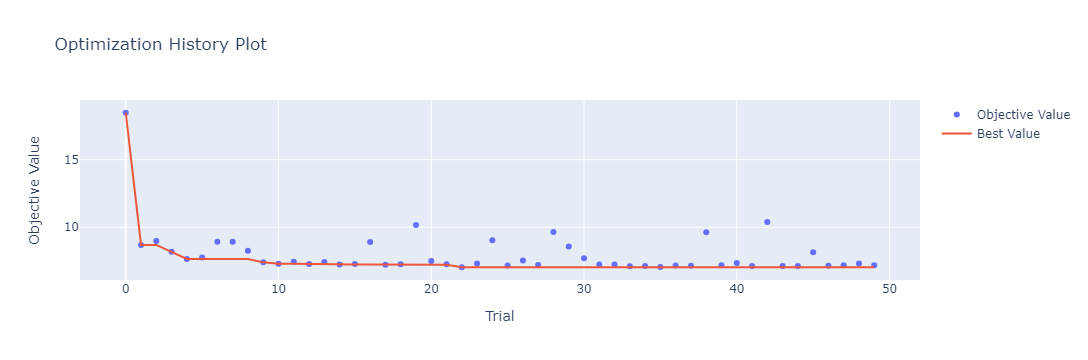

[I 2024-11-25 23:23:38,264] A new study created in memory with name: no-name-fd8e146f-b100-47d1-8784-41d4b8ba484e


Test RMSE for Particle Size: 7.643284916466348


[I 2024-11-25 23:23:38,640] Trial 0 finished with value: 0.37723626169955654 and parameters: {'learning_rate': 0.034273887399802715, 'max_depth': 6, 'min_child_weight': 6.996553050224428, 'subsample': 0.6651228707028676, 'colsample_bytree': 0.663392086154075}. Best is trial 0 with value: 0.37723626169955654.
[I 2024-11-25 23:23:39,105] Trial 1 finished with value: 0.06920912068285848 and parameters: {'learning_rate': 0.10178967036353413, 'max_depth': 8, 'min_child_weight': 3.6100038451232583, 'subsample': 0.7525443307567834, 'colsample_bytree': 0.98718368637238}. Best is trial 1 with value: 0.06920912068285848.
[I 2024-11-25 23:23:39,658] Trial 2 finished with value: 0.2030240535619841 and parameters: {'learning_rate': 0.18180987138680207, 'max_depth': 8, 'min_child_weight': 6.422583379138474, 'subsample': 0.7291442268371083, 'colsample_bytree': 0.6734447410707813}. Best is trial 1 with value: 0.06920912068285848.
[I 2024-11-25 23:23:39,849] Trial 3 finished with value: 0.2583295418344

Best parameters for Yield: {'learning_rate': 0.23775852997350022, 'max_depth': 7, 'min_child_weight': 5.47530566036175, 'subsample': 0.7307385690726792, 'colsample_bytree': 0.969986574311987}


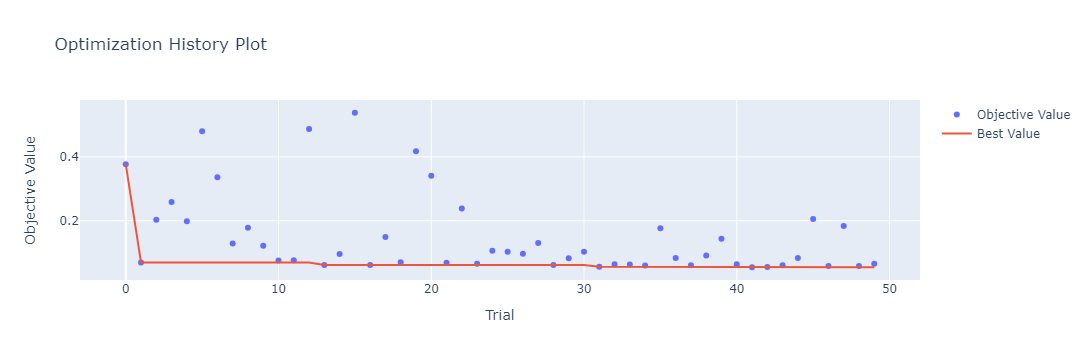

Test RMSE for Yield: 0.0671601077737555


In [49]:
import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import optuna.visualization as vis

# Load your dataset from Excel
data = pd.read_excel("crystallisation_data.xlsx")

# Features (X) and target variables (y) for Particle Size and Yield
X = data[['V_stage1', 'V_stage2', 'V_stage3', 'T_stage1', 'T_stage2', 'T_stage3', 'feed_flowrate', 'seed_flowrate']]
y_particle_size = data['particle_size']  # Target for Particle Size
y_yield = data['yield']  # Target for Yield

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)  # Normalized features

# Split the data into training, validation, and test sets for both targets
X_train, X_temp, y_train_ps, y_temp_ps, y_train_yield, y_temp_yield = train_test_split(X_normalized, y_particle_size, y_yield, test_size=0.4, random_state=42)
X_val, X_test, y_val_ps, y_test_ps, y_val_yield, y_test_yield = train_test_split(X_temp, y_temp_ps, y_temp_yield, test_size=0.5, random_state=42)

# Optuna objective function for hyperparameter tuning
def objective(trial):
    # Suggest hyperparameters
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        'min_child_weight': trial.suggest_float("min_child_weight", 1, 10),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        # Removed n_estimators from here
    }

    # Train and validate the XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train_ps)
    dval = xgb.DMatrix(X_val, label=y_val_ps)

    evals = [(dtrain, "train"), (dval, "eval")]

    # Use num_boost_round instead of n_estimators
    model = xgb.train(
        param,
        dtrain,
        num_boost_round=200,  # This is where the number of boosting rounds is defined
        evals=evals,
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Predict on the validation set
    y_val_pred = model.predict(dval)

    # Calculate RMSE using the new way (for version 1.6 onwards)
    rmse_val = np.sqrt(mean_squared_error(y_val_ps, y_val_pred))  # Direct RMSE calculation
    return rmse_val

# Run Optuna optimization for Particle Size
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best parameters
print("Best parameters for Particle Size:", study.best_params)

# Visualizations

# 1. Optimization history
fig_optimization_history = vis.plot_optimization_history(study)
fig_optimization_history.show()

# Train final model using best parameters for Particle Size
best_params_ps = study.best_params
dtrain_ps = xgb.DMatrix(X_train, label=y_train_ps)
dtest_ps = xgb.DMatrix(X_test)

final_model_ps = xgb.train(best_params_ps, dtrain_ps, num_boost_round=200)

# Evaluate the final model on the test set for Particle Size
y_test_pred_ps = final_model_ps.predict(dtest_ps)
test_rmse_ps = np.sqrt(mean_squared_error(y_test_ps, y_test_pred_ps))  # Calculate RMSE directly
print("Test RMSE for Particle Size:", test_rmse_ps)

# Now repeat for Yield (you can copy this part with minor changes)
# Optuna objective function for Yield
def objective_yield(trial):
    # Suggest hyperparameters
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        'min_child_weight': trial.suggest_float("min_child_weight", 1, 10),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        # Removed n_estimators from here
    }

    # Train and validate the XGBoost model for Yield
    dtrain = xgb.DMatrix(X_train, label=y_train_yield)
    dval = xgb.DMatrix(X_val, label=y_val_yield)

    evals = [(dtrain, "train"), (dval, "eval")]

    model = xgb.train(
        param,
        dtrain,
        num_boost_round=200,  # This is where the number of boosting rounds is defined
        evals=evals,
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Predict on the validation set
    y_val_pred = model.predict(dval)

    # Calculate RMSE for Yield
    rmse_val = np.sqrt(mean_squared_error(y_val_yield, y_val_pred))
    return rmse_val

# Run Optuna optimization for Yield
study_yield = optuna.create_study(direction="minimize")
study_yield.optimize(objective_yield, n_trials=50)

# Best parameters for Yield
print("Best parameters for Yield:", study_yield.best_params)

# Visualizations

# 1. Optimization history for Yield
fig_optimization_history_yield = vis.plot_optimization_history(study_yield)
fig_optimization_history_yield.show()

# Train final model using best parameters for Yield
best_params_yield = study_yield.best_params
dtrain_yield = xgb.DMatrix(X_train, label=y_train_yield)
dtest_yield = xgb.DMatrix(X_test)

final_model_yield = xgb.train(best_params_yield, dtrain_yield, num_boost_round=200)

# Evaluate the final model on the test set for Yield
y_test_pred_yield = final_model_yield.predict(dtest_yield)
test_rmse_yield = np.sqrt(mean_squared_error(y_test_yield, y_test_pred_yield))  # Calculate RMSE directly
print("Test RMSE for Yield:", test_rmse_yield)

In [45]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

# Load your dataset from Excel
data = pd.read_excel("crystallisation_data.xlsx")

# Features (X) and target variables (y)
X = data[['V_stage1', 'V_stage2', 'V_stage3', 'T_stage1', 'T_stage2', 'T_stage3', 'feed_flowrate', 'seed_flowrate']]

# Particle Size target
y_particle_size = data['particle_size']  # Target 1
# Yield target
y_yield = data['yield']  # Target 2

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)  # Normalized features

# Split the data into training, validation, and test sets for particle size
X_train_ps, X_temp_ps, y_train_ps, y_temp_ps = train_test_split(X_normalized, y_particle_size, test_size=0.4, random_state=42)
X_val_ps, X_test_ps, y_val_ps, y_test_ps = train_test_split(X_temp_ps, y_temp_ps, test_size=0.5, random_state=42)

# Split the data into training, validation, and test sets for yield
X_train_yield, X_temp_yield, y_train_yield, y_temp_yield = train_test_split(X_normalized, y_yield, test_size=0.4, random_state=42)
X_val_yield, X_test_yield, y_val_yield, y_test_yield = train_test_split(X_temp_yield, y_temp_yield, test_size=0.5, random_state=42)

# Objective function for Bayesian Optimization for Particle Size
def objective_particle_size(learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, n_estimators):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'n_estimators': int(n_estimators),
    }
    
    dtrain = xgb.DMatrix(X_train_ps, label=y_train_ps)
    dval = xgb.DMatrix(X_val_ps, label=y_val_ps)
    evals = [(dtrain, "train"), (dval, "eval")]

    model = xgb.train(param, dtrain, num_boost_round=200, evals=evals, early_stopping_rounds=10, verbose_eval=False)

    # Predict on the validation set
    y_val_pred = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val_ps, y_val_pred))
    
    return -rmse  # Bayesian Optimization maximizes the objective, so we return negative RMSE

# Objective function for Bayesian Optimization for Yield
def objective_yield(learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, n_estimators):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'n_estimators': int(n_estimators),
    }
    
    dtrain = xgb.DMatrix(X_train_yield, label=y_train_yield)
    dval = xgb.DMatrix(X_val_yield, label=y_val_yield)
    evals = [(dtrain, "train"), (dval, "eval")]

    model = xgb.train(param, dtrain, num_boost_round=200, evals=evals, early_stopping_rounds=10, verbose_eval=False)

    # Predict on the validation set
    y_val_pred = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val_yield, y_val_pred))
    
    return -rmse  # Bayesian Optimization maximizes the objective, so we return negative RMSE

# Perform Bayesian Optimization for Particle Size
pbounds = {
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'n_estimators': (50, 500)
}

optimizer_ps = BayesianOptimization(f=objective_particle_size, pbounds=pbounds, random_state=42)
optimizer_ps.maximize(init_points=5, n_iter=45)

# Print best parameters for Particle Size
print("Best parameters for Particle Size:", optimizer_ps.max)

# Perform Bayesian Optimization for Yield
optimizer_yield = BayesianOptimization(f=objective_yield, pbounds=pbounds, random_state=42)
optimizer_yield.maximize(init_points=5, n_iter=45)

# Print best parameters for Yield
print("Best parameters for Yield:", optimizer_yield.max)

# Train and evaluate final models using the best parameters

# For Particle Size
best_params_ps = optimizer_ps.max['params']
param_ps = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': best_params_ps['learning_rate'],
    'max_depth': int(best_params_ps['max_depth']),
    'min_child_weight': best_params_ps['min_child_weight'],
    'subsample': best_params_ps['subsample'],
    'colsample_bytree': best_params_ps['colsample_bytree'],
    'n_estimators': int(best_params_ps['n_estimators']),
}

dtrain_ps = xgb.DMatrix(X_train_ps, label=y_train_ps)
dtest_ps = xgb.DMatrix(X_test_ps)
final_model_ps = xgb.train(param_ps, dtrain_ps, num_boost_round=200)

# Evaluate on test set for Particle Size
y_test_pred_ps = final_model_ps.predict(dtest_ps)
test_rmse_ps = np.sqrt(mean_squared_error(y_test_ps, y_test_pred_ps))
print("Test RMSE for Particle Size:", test_rmse_ps)

# For Yield
best_params_yield = optimizer_yield.max['params']
param_yield = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': best_params_yield['learning_rate'],
    'max_depth': int(best_params_yield['max_depth']),
    'min_child_weight': best_params_yield['min_child_weight'],
    'subsample': best_params_yield['subsample'],
    'colsample_bytree': best_params_yield['colsample_bytree'],
    'n_estimators': int(best_params_yield['n_estimators']),
}

dtrain_yield = xgb.DMatrix(X_train_yield, label=y_train_yield)
dtest_yield = xgb.DMatrix(X_test_yield)
final_model_yield = xgb.train(param_yield, dtrain_yield, num_boost_round=200)

# Evaluate on test set for Yield
y_test_pred_yield = final_model_yield.predict(dtest_yield)
test_rmse_yield = np.sqrt(mean_squared_error(y_test_yield, y_test_pred_yield))
print("Test RMSE for Yield:", test_rmse_yield)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -7.998    | 0.6873    | 0.2857    | 8.124     | 6.388     | 120.2     | 0.578     |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 2         | -8.725    | 0.529     | 0.2612    | 7.208     | 7.373     | 59.26     | 0.985     |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 3         | -8.084    | 0.9162    | 0.07158   | 4.273     | 2.651     | 186.9     | 0.7624    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 4         | -7.937    | 0.716     | 0.09446   | 7.283     | 2.255     | 181.5     | 0.6832    |
| 5         | -7.844    | 0.728     | 0.2377    | 4.398     | 5.628     | 316.6     | 0.5232    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 6         | -8.52     | 0.6937    | 0.106     | 9.964     | 1.274     | 157.5     | 0.5343    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 7         | -8.018    | 0.6533    | 0.2181    | 8.155     | 4.413     | 304.5     | 0.9109    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 8         | -8.091    | 0.7008    | 0.1483    | 8.073     | 1.249     | 329.9     | 0.9179    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 9         | -9.121    | 0.5058    | 0.1071    | 4.155     | 2.58      | 102.9     | 0.5151    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 10        | -7.634    | 0.6617    | 0.2943    | 4.402     | 9.906     | 132.9     | 0.7976    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 11        | -8.912    | 0.5324    | 0.1209    | 9.223     | 1.005     | 132.3     | 0.7589    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 12        | -8.605    | 0.9363    | 0.2849    | 3.57      | 9.317     | 135.6     | 0.5226    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 13        | -7.683    | 0.8687    | 0.2396    | 7.035     | 4.514     | 307.5     | 0.5372    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 14        | -9.491    | 0.861     | 0.01832   | 8.415     | 6.999     | 360.5     | 0.7682    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 15        | -7.246    | 0.9378    | 0.107     | 5.352     | 9.467     | 296.4     | 0.6121    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 16        | -7.503    | 0.7193    | 0.2945    | 4.853     | 5.724     | 176.9     | 0.7857    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 17        | -8.995    | 0.5594    | 0.112     | 8.216     | 7.133     | 303.9     | 0.6787    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 18        | -7.814    | 0.6737    | 0.2065    | 6.411     | 1.825     | 56.84     | 0.6104    |
| 19        | -7.336    | 0.8248    | 0.2623    | 6.915     | 3.977     | 477.8     | 0.7786    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 20        | -7.255    | 0.7619    | 0.0505    | 6.34      | 5.801     | 99.94     | 0.649     |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 21        | -10.95    | 0.6129    | 0.04061   | 4.105     | 5.82      | 406.7     | 0.8764    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 22        | -9.407    | 0.611     | 0.1915    | 7.142     | 1.115     | 421.3     | 0.6348    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 23        | -9.065    | 0.5522    | 0.2252    | 7.084     | 9.309     | 134.9     | 0.5992    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 24        | -7.155    | 0.9572    | 0.0485    | 6.495     | 7.975     | 276.6     | 0.5411    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 25        | -7.37     | 0.8152    | 0.06907   | 5.188     | 2.786     | 121.8     | 0.986     |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 26        | -8.728    | 0.9143    | 0.2137    | 3.817     | 4.781     | 80.77     | 0.5187    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 27        | -7.431    | 0.8669    | 0.2267    | 7.134     | 4.392     | 307.8     | 0.6037    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 28        | -7.204    | 0.9789    | 0.06566   | 6.721     | 6.944     | 277.4     | 0.7133    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 29        | -7.44     | 0.9736    | 0.2602    | 8.241     | 4.136     | 309.5     | 0.6409    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 30        | -7.363    | 0.9601    | 0.1919    | 7.209     | 1.689     | 308.2     | 0.9982    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 31        | -7.959    | 0.734     | 0.08751   | 8.613     | 9.021     | 277.5     | 0.8397    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 32        | -7.345    | 0.636     | 0.1679    | 5.442     | 3.213     | 309.8     | 0.9261    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 33        | -7.494    | 0.7134    | 0.07918   | 5.004     | 6.254     | 274.6     | 0.6955    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 34        | -7.446    | 0.6521    | 0.1938    | 4.21      | 8.077     | 277.4     | 0.9059    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 35        | -7.739    | 0.7451    | 0.2766    | 7.138     | 8.751     | 99.02     | 0.7784    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 36        | -8.921    | 0.9625    | 0.1403    | 3.19      | 9.776     | 294.2     | 0.8659    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 37        | -8.144    | 0.6251    | 0.2922    | 7.288     | 8.87      | 297.2     | 0.5186    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 38        | -7.859    | 0.8401    | 0.193     | 8.828     | 5.258     | 98.46     | 0.7231    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 39        | -7.192    | 0.9681    | 0.1844    | 7.284     | 4.952     | 275.4     | 0.9006    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 40        | -7.339    | 0.6686    | 0.2835    | 5.295     | 3.882     | 277.6     | 0.9439    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 41        | -7.25     | 0.9947    | 0.05304   | 6.365     | 1.832     | 274.6     | 0.5299    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 42        | -7.694    | 0.9235    | 0.1571    | 8.557     | 2.617     | 276.0     | 0.8173    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 43        | -8.901    | 0.9293    | 0.1547    | 3.005     | 2.255     | 274.7     | 0.5557    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 44        | -7.916    | 0.6655    | 0.2745    | 8.23      | 3.59      | 272.3     | 0.996     |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 45        | -7.657    | 0.7656    | 0.1877    | 4.823     | 5.392     | 97.51     | 0.7132    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 46        | -7.441    | 0.7002    | 0.2655    | 5.116     | 6.237     | 280.1     | 0.9164    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 47        | -7.316    | 0.8996    | 0.2263    | 7.702     | 7.467     | 273.8     | 0.723     |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 48        | -8.395    | 0.5913    | 0.1384    | 5.239     | 9.951     | 274.1     | 0.6424    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 49        | -7.51     | 0.9615    | 0.1947    | 4.147     | 9.892     | 298.9     | 0.8354    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 50        | -7.285    | 0.9514    | 0.1604    | 7.655     | 4.003     | 280.2     | 0.9403    |
Best parameters for Particle Size: {'target': -7.155126536684166, 'params': {'colsample_bytree': 0.957205988931138, 'learning_rate': 0.04849668904855349, 'max_depth': 6.4954608860085985, 'min_child_weight': 7.975182623592539, 'n_estimators': 276.56574200850093, 'subsample': 0.5410730345309005}}
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -0.1773   | 0.6873    | 0.2857    | 8.124     | 6.388     | 120.2     | 0.578     |
| 2         | -0.3646   | 0.529     | 0.2612    | 7.208     | 7.373     | 59.26     | 0.985     |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 3         | -0.356    | 0.9162    | 0.07158   | 4.273     | 2.651     | 186.9     | 0.7624    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 4         | -0.2513   | 0.716     | 0.09446   | 7.283     | 2.255     | 181.5     | 0.6832    |
| 5         | -0.4026   | 0.728     | 0.2377    | 4.398     | 5.628     | 316.6     | 0.5232    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 6         | -0.1032   | 0.7517    | 0.241     | 8.176     | 6.81      | 120.1     | 0.7735    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 7         | -0.1686   | 0.7254    | 0.2732    | 7.872     | 7.336     | 120.4     | 0.791     |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 8         | -0.09184  | 0.988     | 0.05805   | 7.355     | 7.574     | 119.4     | 0.6085    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 9         | -0.4112   | 0.6052    | 0.1703    | 8.153     | 7.374     | 118.5     | 0.9264    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 10        | -0.4171   | 0.6157    | 0.1512    | 6.729     | 7.602     | 120.2     | 0.7111    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 11        | -0.1131   | 0.8724    | 0.1687    | 7.536     | 7.581     | 119.3     | 0.6864    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 12        | -0.1609   | 0.7311    | 0.2818    | 8.831     | 6.463     | 120.6     | 0.7875    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 13        | -0.08223  | 0.9656    | 0.0446    | 8.591     | 7.146     | 120.4     | 0.8122    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 14        | -0.2496   | 0.6348    | 0.09162   | 8.93      | 8.092     | 120.7     | 0.7113    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 15        | -0.05822  | 0.9698    | 0.1764    | 9.81      | 7.061     | 121.1     | 0.9939    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 16        | -0.1904   | 0.9751    | 0.01795   | 9.496     | 7.331     | 121.6     | 0.5219    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 17        | -0.1076   | 0.7748    | 0.206     | 9.894     | 6.601     | 121.9     | 0.8104    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 18        | -0.2472   | 0.6806    | 0.1125    | 9.682     | 5.754     | 120.8     | 0.548     |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 19        | -0.06689  | 0.8755    | 0.2568    | 9.327     | 7.649     | 119.8     | 0.6815    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 20        | -0.1146   | 0.8119    | 0.1613    | 9.673     | 8.664     | 119.3     | 0.9048    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 21        | -0.1857   | 0.6699    | 0.2737    | 9.069     | 7.217     | 119.4     | 0.9083    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 22        | -0.4039   | 0.6088    | 0.1757    | 8.242     | 9.594     | 119.2     | 0.5199    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 23        | -0.1965   | 0.6717    | 0.1849    | 9.614     | 5.551     | 123.4     | 0.8192    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 24        | -0.09751  | 0.7678    | 0.1824    | 7.964     | 5.688     | 123.1     | 0.8519    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 25        | -0.06261  | 0.9969    | 0.2355    | 9.809     | 6.822     | 120.4     | 0.6709    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 26        | -0.05631  | 0.8886    | 0.2989    | 8.443     | 4.658     | 122.4     | 0.9638    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 27        | -0.05477  | 0.9412    | 0.2441    | 8.002     | 4.316     | 124.2     | 0.9724    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 28        | -0.1359   | 0.8373    | 0.09584   | 7.34      | 4.731     | 121.6     | 0.6017    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 29        | -0.5545   | 0.616     | 0.05018   | 7.339     | 4.86      | 124.4     | 0.9626    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 30        | -0.5507   | 0.767     | 0.1471    | 3.147     | 6.207     | 333.3     | 0.816     |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 31        | -0.1039   | 0.8567    | 0.2761    | 8.604     | 5.194     | 121.6     | 0.5346    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 32        | -0.2277   | 0.727     | 0.1458    | 8.162     | 3.591     | 123.4     | 0.5188    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 33        | -0.3899   | 0.615     | 0.2076    | 8.965     | 4.415     | 121.7     | 0.7985    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 34        | -0.05949  | 0.9985    | 0.1801    | 9.187     | 5.307     | 122.6     | 0.9899    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 35        | -0.05614  | 0.879     | 0.2709    | 8.549     | 4.328     | 123.0     | 0.9961    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 36        | -0.05531  | 0.9305    | 0.2175    | 8.725     | 6.466     | 121.8     | 0.9462    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 37        | -0.258    | 0.922     | 0.01331   | 8.265     | 5.334     | 122.2     | 0.5099    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 38        | -0.3783   | 0.5664    | 0.2428    | 8.56      | 4.245     | 124.8     | 0.8508    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 39        | -0.3142   | 0.7344    | 0.0596    | 8.706     | 4.604     | 122.8     | 0.6839    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 40        | -0.1518   | 0.7875    | 0.0725    | 9.035     | 6.502     | 121.5     | 0.6711    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 41        | -0.239    | 0.6838    | 0.1446    | 8.528     | 6.045     | 116.4     | 0.5459    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 42        | -0.3744   | 0.5865    | 0.2403    | 6.816     | 4.726     | 154.7     | 0.7674    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 43        | -0.5064   | 0.5999    | 0.0881    | 9.047     | 5.43      | 122.2     | 0.9394    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 44        | -0.5659   | 0.5276    | 0.04828   | 8.16      | 5.651     | 123.1     | 0.8445    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 45        | -0.06653  | 0.9689    | 0.1445    | 9.394     | 7.356     | 119.9     | 0.8275    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 46        | -0.1911   | 0.716     | 0.2956    | 9.561     | 7.618     | 119.7     | 0.6466    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 47        | -0.3106   | 0.8617    | 0.01974   | 6.476     | 9.895     | 169.8     | 0.5428    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 48        | -0.5057   | 0.9023    | 0.2388    | 3.635     | 1.407     | 458.7     | 0.8129    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 49        | -0.334    | 0.9898    | 0.08988   | 4.097     | 7.473     | 191.9     | 0.9182    |


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




| 50        | -0.5332   | 0.5514    | 0.07511   | 9.956     | 9.035     | 302.7     | 0.9003    |
Best parameters for Yield: {'target': -0.05477023012778871, 'params': {'colsample_bytree': 0.9411831763249676, 'learning_rate': 0.24412935214360815, 'max_depth': 8.001602160704602, 'min_child_weight': 4.316249486717339, 'n_estimators': 124.23078784114571, 'subsample': 0.9723998649166927}}


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




Test RMSE for Particle Size: 7.686639263385343


C:\Users\xdb13122\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.




Test RMSE for Yield: 0.059814020083053795


both method with hyper parameter tuning gave similar performance metrics with optimised hyper parameters in comparision to original XGBoost model.